In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

In [2]:
raw_dataset = pd.read_csv("reiseversicherung.csv")
dataset = raw_dataset.copy()

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63326 entries, 0 to 63325
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Agenturname        63326 non-null  object 
 1   Agenturtyp         63326 non-null  object 
 2   Vertriebskanal     63326 non-null  object 
 3   Produktname        63326 non-null  object 
 4   Leistungseintritt  63326 non-null  object 
 5   Reisedauer         63326 non-null  int64  
 6   Reiseziel          63326 non-null  object 
 7   Nettoumsatz        63326 non-null  float64
 8   Kommission         63326 non-null  float64
 9   Geschlecht         18219 non-null  object 
 10  Alter              63326 non-null  int64  
dtypes: float64(2), int64(2), object(7)
memory usage: 5.3+ MB


In [4]:
#The info output suggests that 'Geschlecht' has Null values so let's check that
dataset.isna().sum()

Agenturname              0
Agenturtyp               0
Vertriebskanal           0
Produktname              0
Leistungseintritt        0
Reisedauer               0
Reiseziel                0
Nettoumsatz              0
Kommission               0
Geschlecht           45107
Alter                    0
dtype: int64

In [5]:
#Drop incomplete column since a majority of entries has Null values there
dataset.drop("Geschlecht", axis=1, inplace=True)

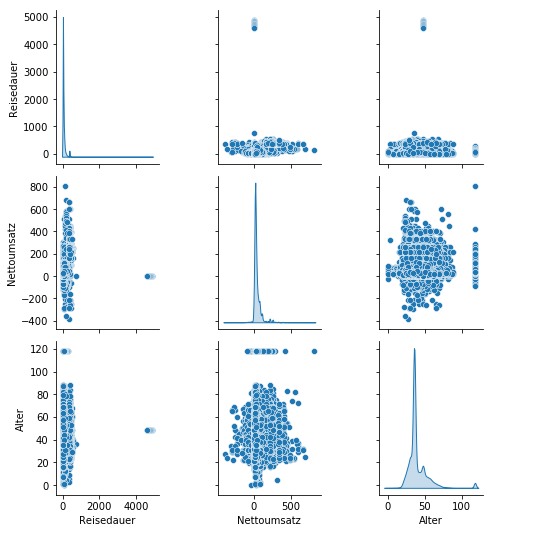

In [6]:
#Let's take a look at the numerical collumns
sns.pairplot(dataset[["Reisedauer", "Nettoumsatz", "Alter"]], diag_kind='kde')
plt.savefig("plots/PairGrid.png")

The age distribution warrants a closer look as it has a peak at over a 100 years which seems unlikely to be correct.

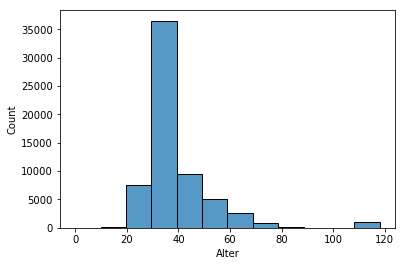

In [7]:
sns.histplot(dataset["Alter"], bins=12, stat='count')
plt.savefig("plots/age_hist.png")

The age distribution looks plausible for travelers, except for the peak at over a 100 years old. It seems unlikely, that this data is correct. Therefore, I will drop the data points where age is over 100 since they seem to be unreliable.

In [8]:
dataset = dataset[dataset["Alter"] <= 100]

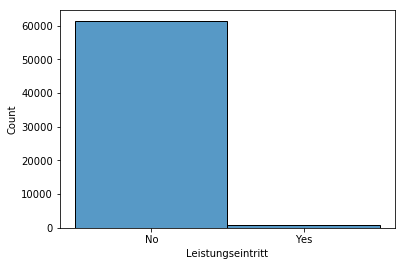

In [9]:
#Let's look at the target variable
sns.histplot(dataset["Leistungseintritt"], stat='count', bins=2)
plt.savefig("plots/target_hist.png")

In [10]:
pos_count = dataset[dataset["Leistungseintritt"] == "Yes"].shape[0]
total_count = dataset.shape[0]

print(pos_count)
print(total_count)
print("Leistungseintritt in {}% der Fälle".format(round(100 * pos_count / total_count, 2)))

917
62342
Leistungseintritt in 1.47% der Fälle


Taking a look at the distribution of the target variable, we can see that it is very uneven. This can lead to problems with the predictor since a predictor who just predicts 'No' every time will still have over 98% accuracy. <br>
To do some preliminary analysis I will split the dataset into two according to the 'Leistungseintritt' variable.

In [11]:
positive = dataset[dataset["Leistungseintritt"] == "Yes"]
negative = dataset[dataset["Leistungseintritt"] == "No"]

#Let's take a look at the top 5 destinations for both cases
positive["Reiseziel"].value_counts()[:10]

SINGAPORE              562
CHINA                   44
AUSTRALIA               37
UNITED STATES           37
THAILAND                33
MALAYSIA                22
UNITED KINGDOM          16
HONG KONG               15
'KOREA REPUBLIC OF'     15
JAPAN                   14
Name: Reiseziel, dtype: int64

In [12]:
negative["Reiseziel"].value_counts()[:10]

SINGAPORE        12674
MALAYSIA          5865
THAILAND          5818
CHINA             4728
AUSTRALIA         3655
INDONESIA         3421
UNITED STATES     2487
PHILIPPINES       2473
HONG KONG         2379
JAPAN             2043
Name: Reiseziel, dtype: int64

The most common destinations seem to also be the ones where the 'Leistungseintritt' is positive most often. Therefore we can not draw any real conclusions yet.

Let us also look at the numerical variables again for the split dataset

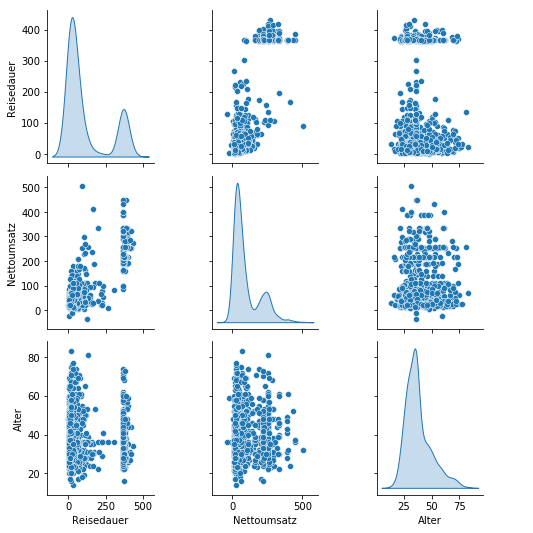

In [13]:
sns.pairplot(positive[["Reisedauer", "Nettoumsatz", "Alter"]], diag_kind='kde')

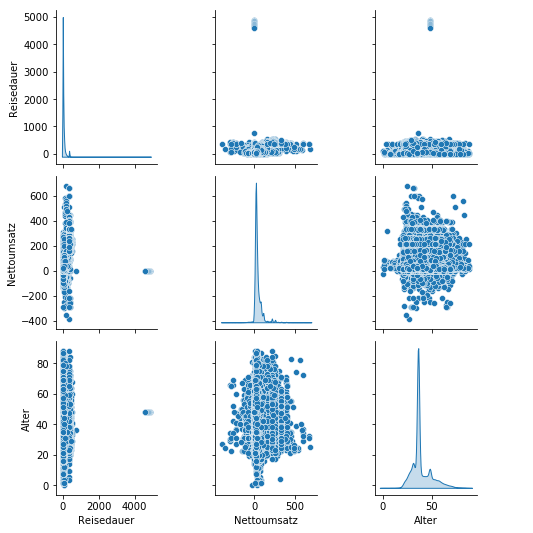

In [14]:
sns.pairplot(negative[["Reisedauer", "Nettoumsatz", "Alter"]], diag_kind='kde')

The distributions seem to generally agree for both cases. The differences can be explained by the difference in samplesize.

## Preprocessing <br>
Let us preprocess the data to use with the predictor model later:
    
<ul>
    <li> Convert the target variable form "Yes" and "No" to binary 1 & 0 </li>
    <li> Convert the rest of the binary columns into 1 & 0 categorical columns </li>
    <li> Convert the rest of the categorical columns with more than 2 categories using one hot encoding </li>
    <li> Rescale the numerical columns to the range [0,1] </li>
</ul>

In [15]:
#Create Target Variable
dataset["Leistungseintritt"] = np.where(dataset["Leistungseintritt"] == "Yes", 1, 0)

#Convert the rest of the binary categorical variables
dataset["Agenturtyp"].replace({'Travel Agency': 0, 'Airlines': 1}, inplace=True)
dataset["Vertriebskanal"].replace({'Offline': 0, 'Online': 1}, inplace=True)

#Convert the multiclass categorical variables using one hot encoding
categorical_columns = ["Agenturname", "Produktname", "Reiseziel"]
dataset = pd.get_dummies(data=dataset, columns=categorical_columns)

#Rescale the numerical collumns
columns_to_rescale = ["Reisedauer", "Nettoumsatz", "Kommission", "Alter"]
scaler = MinMaxScaler()
dataset[columns_to_rescale] = scaler.fit_transform(dataset[columns_to_rescale])

#seperate the feature columns and the label column
labels = dataset["Leistungseintritt"]
features = dataset.drop('Leistungseintritt', axis='columns')

#prepare data for training
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2, 
                                                                            random_state=5, stratify=labels)
#oversample the underrepresented case of 'Leistungseintritt'='Yes' via blind copies
tr_features_class1 = features_train[labels_train == 1]
tr_label_class1 = labels_train[labels_train == 1]
tr_features_class0 = features_train[labels_train == 0]
tr_label_class0 = labels_train[labels_train == 0]

train_class1 = pd.concat([tr_features_class1, tr_label_class1], axis=1)
train_class0 = pd.concat([tr_features_class0, tr_label_class0], axis=1)

#Lets oversample to the point we have equal entries in both classes
train_class1_over = train_class1.sample(train_class0.shape[0], replace=True)

#Concate the classes back together
train_data_over = pd.concat([train_class0, train_class1_over], axis=0)

#reseperate features and labels
train_labels_over = train_data_over["Leistungseintritt"]
train_features_over = train_data_over.drop('Leistungseintritt', axis='columns')

C:\Users\Johannes\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


# Model <br>
Now we build and train a model for our predictor. I chose to keep it simple and just use a simple Neural net with two hidden layers. I used one dense layers for the prediction. Since we did oversample a part of our dataset we have to be careful about overfitting, so I also inculded a Droput regularization layer.

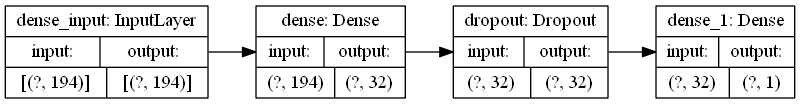

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, input_shape=(194,), activation='relu'),
    tf.keras.layers.Dropout(0.5),
    #tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

#Lest visualize the simple model we built
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [17]:
#fit the model making sure to shuffle the data
history = model.fit(train_features_over, train_labels_over, epochs=200, batch_size=128, shuffle=True)

Epoch 1/200
768/768 [==============================] - 1s 970us/step - loss: 0.5297 - accuracy: 0.7549
Epoch 2/200
768/768 [==============================] - 1s 1ms/step - loss: 0.5005 - accuracy: 0.7766
Epoch 3/200
768/768 [==============================] - 1s 1ms/step - loss: 0.4910 - accuracy: 0.7800
Epoch 4/200
768/768 [==============================] - 1s 1ms/step - loss: 0.4868 - accuracy: 0.7820
Epoch 5/200
768/768 [==============================] - 1s 968us/step - loss: 0.4817 - accuracy: 0.7853
Epoch 6/200
768/768 [==============================] - 1s 874us/step - loss: 0.4781 - accuracy: 0.78620s - loss: 0.4782 - accuracy: 0.78
Epoch 7/200
768/768 [==============================] - 1s 920us/step - loss: 0.4768 - accuracy: 0.7866
Epoch 8/200
768/768 [==============================] - 1s 938us/step - loss: 0.4749 - accuracy: 0.7878
Epoch 9/200
768/768 [==============================] - 1s 1ms/step - loss: 0.4727 - accuracy: 0.7889
Epoch 10/200
768/768 [=========================

768/768 [==============================] - 1s 944us/step - loss: 0.4174 - accuracy: 0.8098
Epoch 80/200
768/768 [==============================] - 1s 898us/step - loss: 0.4167 - accuracy: 0.8100
Epoch 81/200
768/768 [==============================] - 1s 1ms/step - loss: 0.4164 - accuracy: 0.8107
Epoch 82/200
768/768 [==============================] - 1s 849us/step - loss: 0.4149 - accuracy: 0.8094
Epoch 83/200
768/768 [==============================] - 1s 874us/step - loss: 0.4152 - accuracy: 0.8092
Epoch 84/200
768/768 [==============================] - 1s 943us/step - loss: 0.4149 - accuracy: 0.8100
Epoch 85/200
768/768 [==============================] - 1s 954us/step - loss: 0.4141 - accuracy: 0.8111
Epoch 86/200
768/768 [==============================] - 1s 857us/step - loss: 0.4140 - accuracy: 0.8102
Epoch 87/200
768/768 [==============================] - 1s 892us/step - loss: 0.4129 - accuracy: 0.8098
Epoch 88/200
768/768 [==============================] - 1s 875us/step - loss: 0

768/768 [==============================] - 1s 1ms/step - loss: 0.3973 - accuracy: 0.8149
Epoch 158/200
768/768 [==============================] - 1s 870us/step - loss: 0.3976 - accuracy: 0.8145
Epoch 159/200
768/768 [==============================] - 1s 918us/step - loss: 0.3972 - accuracy: 0.8137
Epoch 160/200
768/768 [==============================] - 1s 930us/step - loss: 0.3974 - accuracy: 0.8141
Epoch 161/200
768/768 [==============================] - 1s 860us/step - loss: 0.3975 - accuracy: 0.8140
Epoch 162/200
768/768 [==============================] - 1s 884us/step - loss: 0.3969 - accuracy: 0.8152
Epoch 163/200
768/768 [==============================] - 1s 869us/step - loss: 0.3960 - accuracy: 0.8155
Epoch 164/200
768/768 [==============================] - 1s 892us/step - loss: 0.3957 - accuracy: 0.8158
Epoch 165/200
768/768 [==============================] - 1s 879us/step - loss: 0.3951 - accuracy: 0.8151
Epoch 166/200
768/768 [==============================] - 1s 886us/step 

Text(0, 0.5, 'Loss')

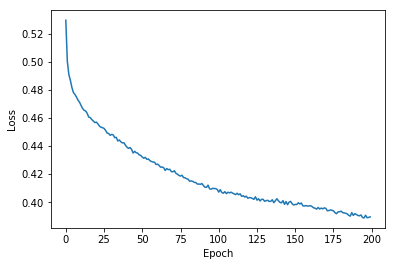

In [18]:
#Lets check conversion by plotting the training loss
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

## Evaluation <br>
Next we evaluate the model. First using the inbuilt evaluate function to get the final loss and accuracy on the test data.
Afterwards we get the predictions for the test data and convert them from the probabilities to the final predicted class labels and calculate precision, recall, f1 score, and the confusion matrix.

In [19]:
model.evaluate(features_test, labels_test)

390/390 [==============================] - 0s 628us/step - loss: 0.5410 - accuracy: 0.7752


[0.5410351157188416, 0.7752025127410889]

In [20]:
predictions = model.predict(features_test)

#find the predicted labels
label_pred = []
for element in predictions:
    if element > 0.5:
        label_pred.append(1)
    else:
        label_pred.append(0)

In [21]:
print(classification_report(labels_test, label_pred))

              precision    recall  f1-score   support

           0       0.99      0.78      0.87     12286
           1       0.05      0.72      0.09       183

   micro avg       0.78      0.78      0.78     12469
   macro avg       0.52      0.75      0.48     12469
weighted avg       0.98      0.78      0.86     12469



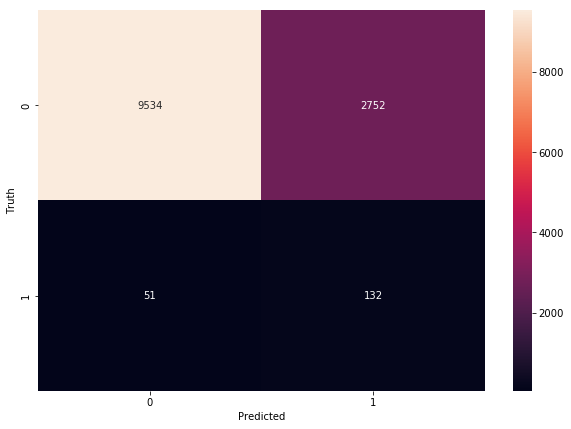

In [22]:
cm = tf.math.confusion_matrix(labels=labels_test, predictions=label_pred)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.savefig("plots/cm.png")

## Saving for deployment <br>
Lastly we save the model so we can deploy it to a server using the TensorFlow serving functionality

In [23]:
tf.saved_model.save(model, "saved_models/serving_01")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_models/serving_01\assets


## Further improvement <br>
Due to lack of time I did not perform basic optimization steps like hyperparameter tuning and pruning to improve the model performance. There are some other additional things we could do to improve functionality of the model:
    
<ul>   
    <li>Include the data preprocessing steps into the actual model (e.g. TensorFlow preprocessing layers) so unprocessed data can be used by the final model in the web application</li>
    <li>Use Synthetic data (Synthetic Minority Oversampling Technique) for oversampling the training data instead of using blind copies. It could also be helful to adjust the loss function to reflect the imbalanced data</li>
    <li>For further analysis we could try to find out which input features from the data set have the biggest impact on the prediction value (e.g. Analysing the derivatives)</li>
</ul>